In [1]:
# code to create boxplots
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
cake = ('c','a','k','e')
print(type(cake))

<class 'tuple'>


In [5]:
cake[1]

'a'

In [20]:
def map_landcover(df):

    lc_group_map = {
    # 1. Agriculture
    10: "Cropland",
    20: "Cropland",
    30: "Cropland",
    40: "Cropland",

    # 2. Forest
    50: "BEV",
    60: "BD", 61: "BD", 62: "BD",
    70: "NEV", 71: "NEV", 72: "NEV",
    80: "ND", 81: "ND", 82: "ND",
    90: "Mixed Forest",
    100: "Mixed Forest",
    160: "Flooded forest",
    170: "Flooded forest",

    # 3. Grassland
    110: "Grassland",
    130: "Grassland",

    # 4. Wetland
    180: "Wetland",

    # 5. Settlement
    190: "Settlement",

    # 6. Other (Shrubland / Sparse / Bare / Water)
    120: "Shrubland",
    121: "Shrubland",
    122: "Shrubland",
    140: "Lichens",
    150: "Sparse",
    151: "Sparse",
    152: "Sparse",
    153: "Sparse",
    200: "Bare",
    201: "Bare",
    202: "Bare",
    220: "Ice"
    }

    df["landcover_group"] = df["landcover"].map(lc_group_map)
    # filter classes with very low samples
    counts = df["landcover_group"].value_counts()
    valid_classes = counts[counts > 20].index

    df = df[df["landcover_group"].isin(valid_classes)]
    return df


In [21]:
def prep_data(path, lat_tuple, lon_tuple):
    ds = xr.open_dataset(path)
    ds['trends'] = ds['__xarray_dataarray_variable__'] *10
    land_cover = xr.open_dataset('/mnt/data7/nfs4/avh_ndvi/sdupuis/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc', engine='netcdf4')
    lc = land_cover.sel(lat=slice(lat_tuple[0], lat_tuple[1]), lon=slice(lon_tuple[0], lon_tuple[1]))
    lc_interp = lc.interp(lat=ds.coords['lat'], lon=ds.coords['lon'], method='nearest')

    trend = ds.where(~np.isnan(lc_interp['lccs_class']))
    landcover = lc_interp.where(~np.isnan(ds['__xarray_dataarray_variable__']))

    trend_1d = trend['trends'].stack(points=("lat", "lon"))
    lc_1d = landcover['lccs_class'].stack(points=("lat", "lon"))
    
    valid = (~np.isnan(trend_1d)) & (~np.isnan(lc_1d))
    trend_1d = trend_1d[valid]
    lc_1d = lc_1d[valid]

    df = pd.DataFrame({
    "trend": trend_1d.values,
    "landcover": lc_1d.values.astype(int)
    })
    df_mapped = map_landcover(df)



    return df_mapped
    

In [40]:
df_trends = prep_data('significant_trends_1981_2007.nc',(72,55), (-168,-150) )

In [27]:
df_2001 = prep_data('significant_trends_noaa_2001_2018.nc',(72,55), (-168,-150))

In [28]:
df_metop = prep_data('significant_trends_metop.nc', (72,55), (-168,-150))

In [31]:
#df_1981 = prep_data('significant_trends_noaa_1981_2001.nc',(72,55), (-168,-150) )

In [23]:
df_trends

,trend,landcover,landcover_group
0,0.619089,120,Shrubland
1,0.660900,120,Shrubland
2,-0.484706,200,Bare
3,0.322026,120,Shrubland
4,0.368594,120,Shrubland
...,...,...,...
62045,0.741107,140,Lichens
62046,0.543709,140,Lichens
62047,0.408276,140,Lichens
62048,0.735362,140,Lichens


In [33]:
result = (
    pd.concat(
        [df_trends, df_2001, df_metop],
        keys=["NOAA-1981-2018", "NOAA-1981-2001", "NOAA-2001-2018", "Metop-2007-2023"],
        names=["Datasets"]
    )
    .reset_index(level="Datasets")
)

In [34]:
result

,Datasets,trend,landcover,landcover_group
0,NOAA-1981-2018,0.619089,120,Shrubland
1,NOAA-1981-2018,0.660900,120,Shrubland
2,NOAA-1981-2018,-0.484706,200,Bare
3,NOAA-1981-2018,0.322026,120,Shrubland
4,NOAA-1981-2018,0.368594,120,Shrubland
...,...,...,...,...
20036,NOAA-2001-2018,1.699982,140,Lichens
20037,NOAA-2001-2018,1.886265,140,Lichens
20038,NOAA-2001-2018,1.238376,180,Wetland
20039,NOAA-2001-2018,1.265392,150,Sparse


In [42]:
# yamal (74,60), lon=slice(65,74)
df_trends_yamal = prep_data('Yamal/yamal_significant_trends_1981_2018.nc',(74,60), (65,74) )
df_trends_yamal_1981 = prep_data('Yamal/yamal_significant_trends_1981_2001.nc',(74,60), (65,74) )
df_trends_yamal_2001 = prep_data('Yamal/yamal_significant_trends_2001_2018.nc',(74,60), (65,74) )
df_trends_yamal_metop = prep_data('Yamal/yamal_significant_trends_2007_2018.nc',(74,60), (65,74) )

In [46]:
result_yamal = (
    pd.concat(
        [df_trends_yamal, df_trends_yamal_1981, df_trends_yamal_2001,df_trends_yamal_metop],
        keys=["NOAA-1981-2018", "NOAA-1981-2001", "NOAA-2001-2018", "Metop-2007-2023"],
        names=["Datasets"]
    )
    .reset_index(level="Datasets")
)

In [51]:
# greenland lat=slice(84,58), lon=slice(-73,-7))
df_trends_gr = prep_data('Greenland/greenland_significant_trends_1981_2018.nc',(84,58), (-73,-7) )
df_trends_gr_1981 = prep_data('Greenland/greenland_significant_trends_1981_2001.nc',(84,58), (-73,-7) )
df_trends_gr_2001 = prep_data('Greenland/greenland_significant_trends_2001_2018.nc',(84,58), (-73,-7) )
df_trends_gr_metop = prep_data('Greenland/greenland_significant_trends_2007_2018.nc',(84,58), (-73,-7) )

In [52]:
result_gr = (
    pd.concat(
        [df_trends_gr, df_trends_gr_1981, df_trends_gr_2001,df_trends_gr_metop],
        keys=["NOAA-1981-2018", "NOAA-1981-2001", "NOAA-2001-2018", "Metop-2007-2023"],
        names=["Datasets"]
    )
    .reset_index(level="Datasets")
)

In [ ]:
# Group them differently! # what happened with greenland ? 

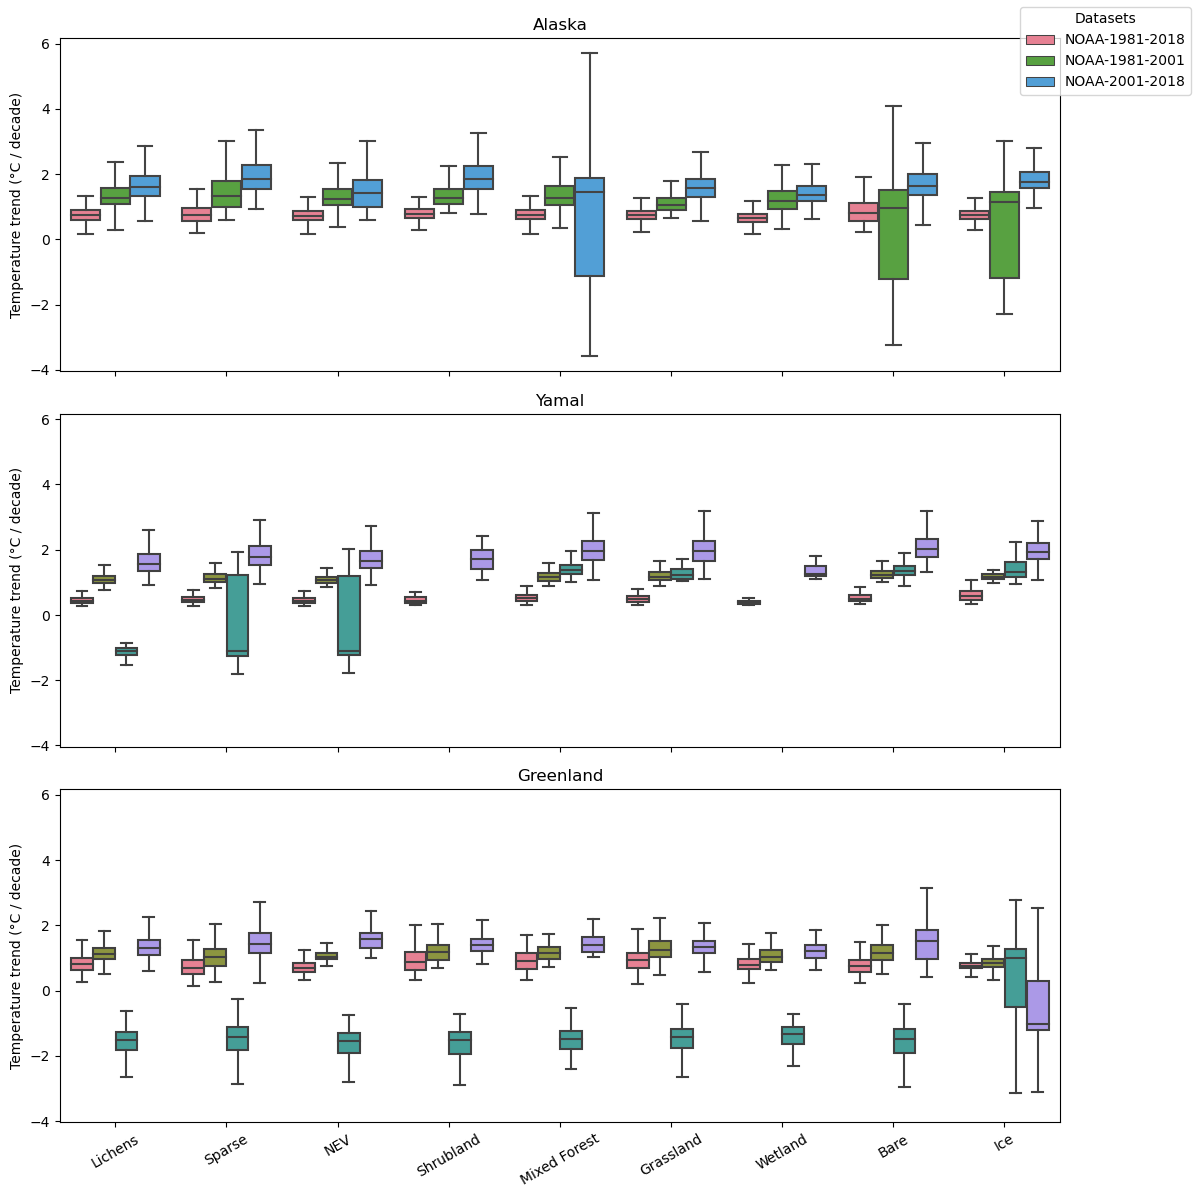

In [54]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 12),
    sharex=True,
    sharey=True
)

dfs = [result, result_yamal, result_gr]          # your three dataframes
titles = ["Alaska", "Yamal", "Greenland"]  # subplot titles

for ax, df, title in zip(axes, dfs, titles):
    sns.boxplot(
        data=df,
        x="landcover_group",
        y="trend",
        hue="Datasets",
        palette="husl",
        showfliers=False,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Temperature trend (°C / decade)")
    ax.legend_.remove()

# Add ONE shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Datasets",
    loc="upper right"
)

plt.xticks(rotation=30)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


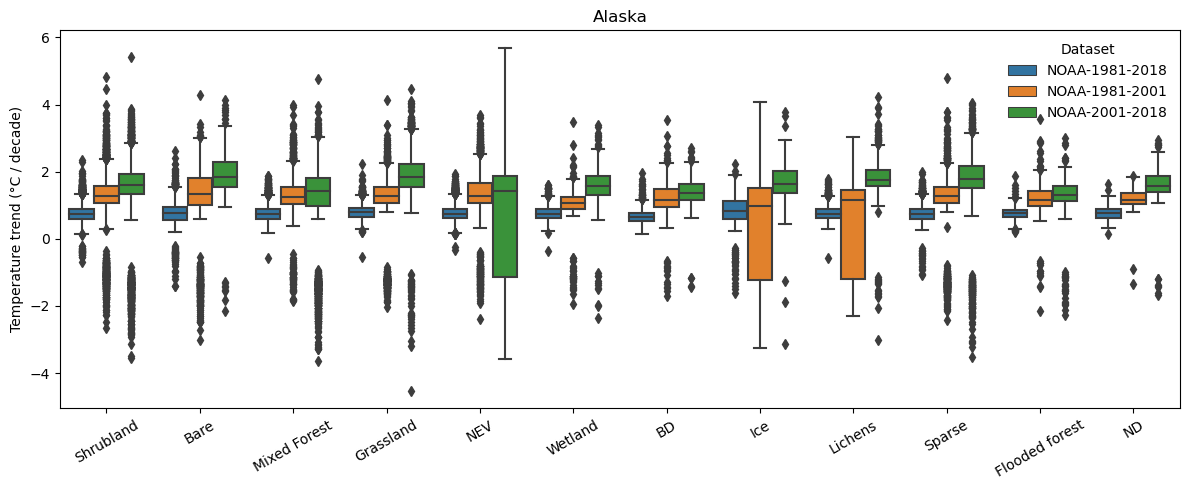

In [44]:
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=result,
    x="landcover_group",
    y="trend",
    hue="Datasets",
)
plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("")
plt.title("Alaska")
plt.xticks(rotation=30)
plt.legend(title="Dataset", frameon=False)
plt.tight_layout()
plt.show()

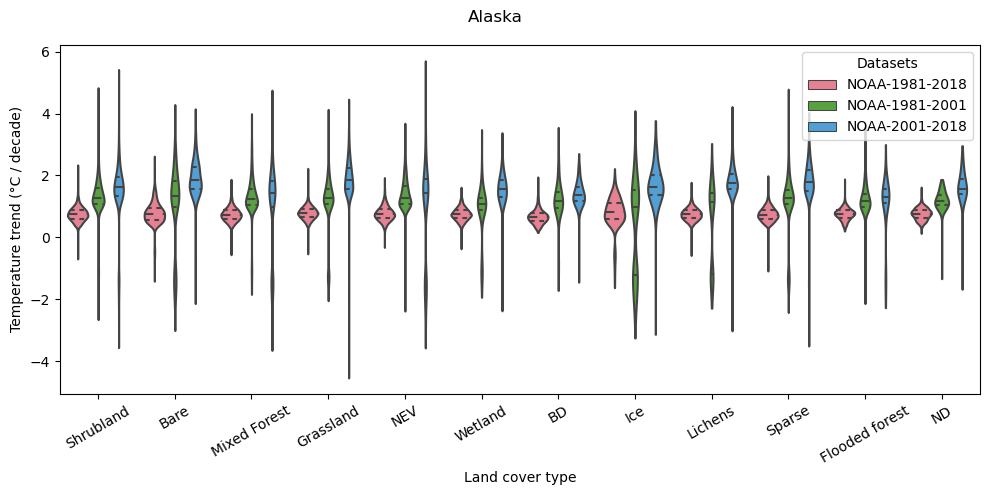

In [45]:
plt.figure(figsize=(10, 5))
sns.violinplot(
    data=result,
    x="landcover_group",
    y="trend",
    hue="Datasets",
    palette="husl",
    cut=0,
    inner="quartile",
    dodge=True
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("Land cover type")
plt.suptitle("Alaska")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


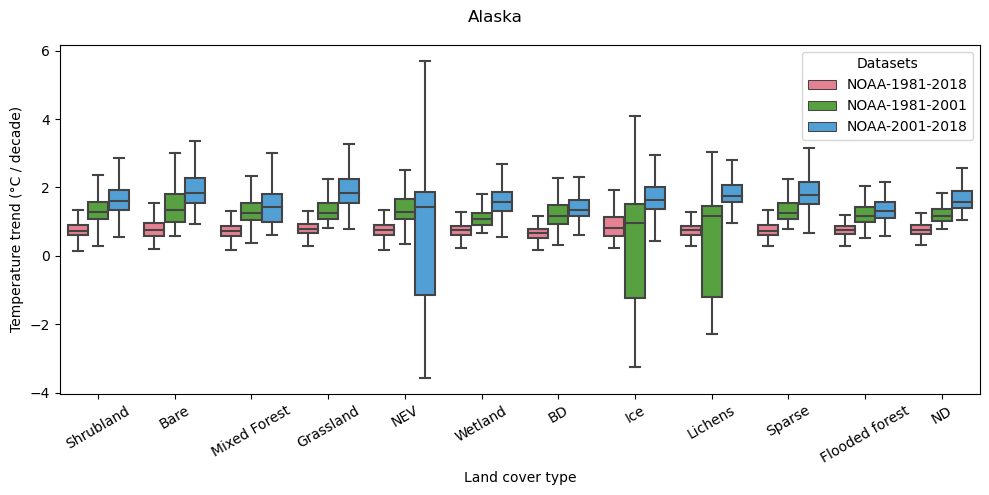

In [35]:
# Group all boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=result,
    x="landcover_group",   # or "landcover"
    y="trend",
    hue='Datasets',
    palette = 'husl',
    showfliers=False
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("Land cover type")
plt.suptitle('Alaska')
plt.xticks(rotation=30)
plt.tight_layout()
#plt.savefig('Alaska_box_plot.png')
plt.show()